In [240]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
import time
%matplotlib notebook

In [241]:
np.random.seed(7)

In [242]:
# visualization tool
class RealTimeVisualizer(Callback):
    def on_train_begin(self, logs={}):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2,1, sharex=True)
        self.fig.suptitle(self.title, fontsize=24)
        self.fig.set_size_inches(20, 8)
        self.index_graph = []
        self.loss_graph = []
        self.val_loss_graph = []
        self.acc_graph = []
        self.val_acc_graph = []
 
    def on_epoch_end(self, epoch, logs={}):
        interval = self.interval
        loss = logs['loss']
        val_loss = logs['val_loss']
        try:
            val_acc = logs['val_acc']
        except:
            val_acc = logs['val_mean_squared_error']    
        try:
            acc = logs['acc']
        except:
            acc = logs['mean_squared_error']
        if epoch%interval == interval-1:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc
            self.loss_graph[int(epoch/interval)] /= interval
            self.val_loss_graph[int(epoch/interval)] /= interval
            self.val_acc_graph[int(epoch/interval)] /= interval
            self.acc_graph[int(epoch/interval)] /= interval
            self.ax1.set_title("loss is:{} val_loss is:{}".format(loss, val_loss))
            self.ax1.plot(self.index_graph, self.loss_graph, '-r')
            self.ax1.plot(self.index_graph, self.val_loss_graph, '-xb')
            self.ax2.set_title("acc is:{} val_acc is:{}".format(acc, val_acc))
            self.ax2.plot(self.index_graph, self.acc_graph, '-r')
            self.ax2.plot(self.index_graph, self.val_acc_graph, '-xb')
            self.ax2.plot(self.index_graph, [self.acc_graph[0]]*len(self.index_graph), '-p')
            self.fig.canvas.draw()
            time.sleep(0.05)
        elif epoch%interval == 0:
            self.loss_graph.append(loss)
            self.val_loss_graph.append(val_loss)
            self.val_acc_graph.append(val_acc)
            self.acc_graph.append(acc)
            self.index_graph.append(epoch)
        else:
            self.loss_graph[int(epoch/interval)] += loss
            self.val_loss_graph[int(epoch/interval)] += val_loss
            self.val_acc_graph[int(epoch/interval)] += val_acc
            self.acc_graph[int(epoch/interval)] += acc

VisualizeCallback = RealTimeVisualizer()
VisualizeCallback.interval = 2
VisualizeCallback.title = "plot"

In [243]:
def setLabel(label, df):
    df['label'] = np.array([label]*len(df))
    return df

def cluster_sequence(df, length=100):
    print(len(df))
    temp_arr = [np.array(df.iloc[i:i+100, :-1]) for i in range(len(df)-100)]
    label_arr = [df.iloc[i, -1] for i in range(len(df)-100)]
    df = pd.DataFrame({'accel':temp_arr, 'label':label_arr})
    print(len(df))
    return df

In [266]:
time_sequence_len = 100
# grab and shuffle data
# 0 represents idle
train_df = pd.read_csv("input/rest0.csv")
train_df = train_df.iloc[:, [2, 3, 4]]
train_df = setLabel(0, train_df)
train_df = cluster_sequence(train_df, length=time_sequence_len)
temp_df = pd.read_csv("input/rest1.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(0, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
temp_df = pd.read_csv("input/rest2.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(0, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
# 1 represents tablework
# temp_df = pd.read_csv("input/internet0.csv")
# temp_df = temp_df.iloc[:, [2, 3, 4]]
# temp_df = setLabel(1, temp_df)
# temp_df = cluster_sequence(temp_df, length=time_sequence_len)
# train_df = train_df.append(temp_df, ignore_index=True)
temp_df = pd.read_csv("input/writing0.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(1, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
temp_df = pd.read_csv("input/table0.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(1, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
# # 2 represents exercise
# temp_df = pd.read_csv("input/exercise0.csv")
# temp_df = temp_df.iloc[:, [2, 3, 4]]
# temp_df = setLabel(2, temp_df)
# temp_df = cluster_sequence(temp_df, length=time_sequence_len)
# train_df = train_df.append(temp_df, ignore_index=True)
# 2 represents walking
temp_df = pd.read_csv("input/walk0.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(2, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
temp_df = pd.read_csv("input/walk1.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(2, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)
temp_df = pd.read_csv("input/walk2.csv")
temp_df = temp_df.iloc[:, [2, 3, 4]]
temp_df = setLabel(2, temp_df)
temp_df = cluster_sequence(temp_df, length=time_sequence_len)
train_df = train_df.append(temp_df, ignore_index=True)

8460
8360
5000
4900
5840
5740
14340
14240
13080
12980
8400
8300
4480
4380
4820
4720


In [267]:
def get_train_data(df, train_portion=0.8):
    # shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    split_point = int(len(df) * train_portion)
    # get sample weight
    counter = df.iloc[:, -1].value_counts().to_dict()
    weights = [0] * len(counter)
    for i in range(len(counter)):
        weights[i] = 1 / float(counter[i])
    weights = np.array(weights)
    weights = weights / weights.min()
    print(weights)
    # get train_data and valid_data
    train_accel = np.array([[vec for vec in item] for item in df.iloc[:split_point, 0]])
    train_label = np.array(df.iloc[:split_point, -1])
    train_label_onehot = to_categorical(train_label)
    train_weight = np.array([weights[i] for i in df.iloc[:split_point, -1]])
    test_accel = np.array([[vec for vec in item] for item in df.iloc[split_point:, 0]])
    test_label = np.array(df.iloc[split_point:, -1])
    test_label_onehot = to_categorical(test_label)
    test_weight = np.array([weights[i] for i in df.iloc[split_point:, -1]])
    
    return {'accel': train_accel, 'label': train_label, 'label_onehot': train_label_onehot, 'label_weight': train_weight},\
           {'accel': test_accel, 'label': test_label, 'label_onehot': test_label_onehot, 'label_weight': test_weight}

In [271]:
# get train and test data
train_data, test_data = get_train_data(train_df, train_portion=0.8)

[ 1.43263158  1.          1.56436782]


In [269]:
accel_input = Input(shape=(time_sequence_len, 3))
# conv feature extraction
x = Conv1D(kernel_size=1, filters=32, activation='relu', name="conv_feature_1")(accel_input)
x = BatchNormalization(axis=1)(x)
conv_feature = Dropout(0.2)(x)
# lstm main feature extractor
x = LSTM(units=16, dropout=0.2, name="lstm_feature_1")(conv_feature)
x = BatchNormalization()(x)
lstm_feature = Dropout(0.2)(x)
# classifiers of probability output
x = Dense(units=16, name='dense_classifier_1', activity_regularizer=l2(0.01))(lstm_feature)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(units=16, name='dense_classifier_2', activity_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
class_probability = Dense(units=3, activation="softmax", name="probability_output")(x)

# Model the network
pattern_analyzer = Model(inputs=[accel_input], outputs=[class_probability])
pattern_analyzer.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
plot_model(model=pattern_analyzer, to_file="temp.png")
# print out summary
pattern_analyzer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
conv_feature_1 (Conv1D)      (None, 100, 32)           128       
_________________________________________________________________
batch_normalization_53 (Batc (None, 100, 32)           400       
_________________________________________________________________
dropout_53 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_feature_1 (LSTM)        (None, 16)                3136      
_________________________________________________________________
batch_normalization_54 (Batc (None, 16)                64        
_________________________________________________________________
dropout_54 (Dropout)         (None, 16)                0         
__________

<IPython.core.display.Javascript object>


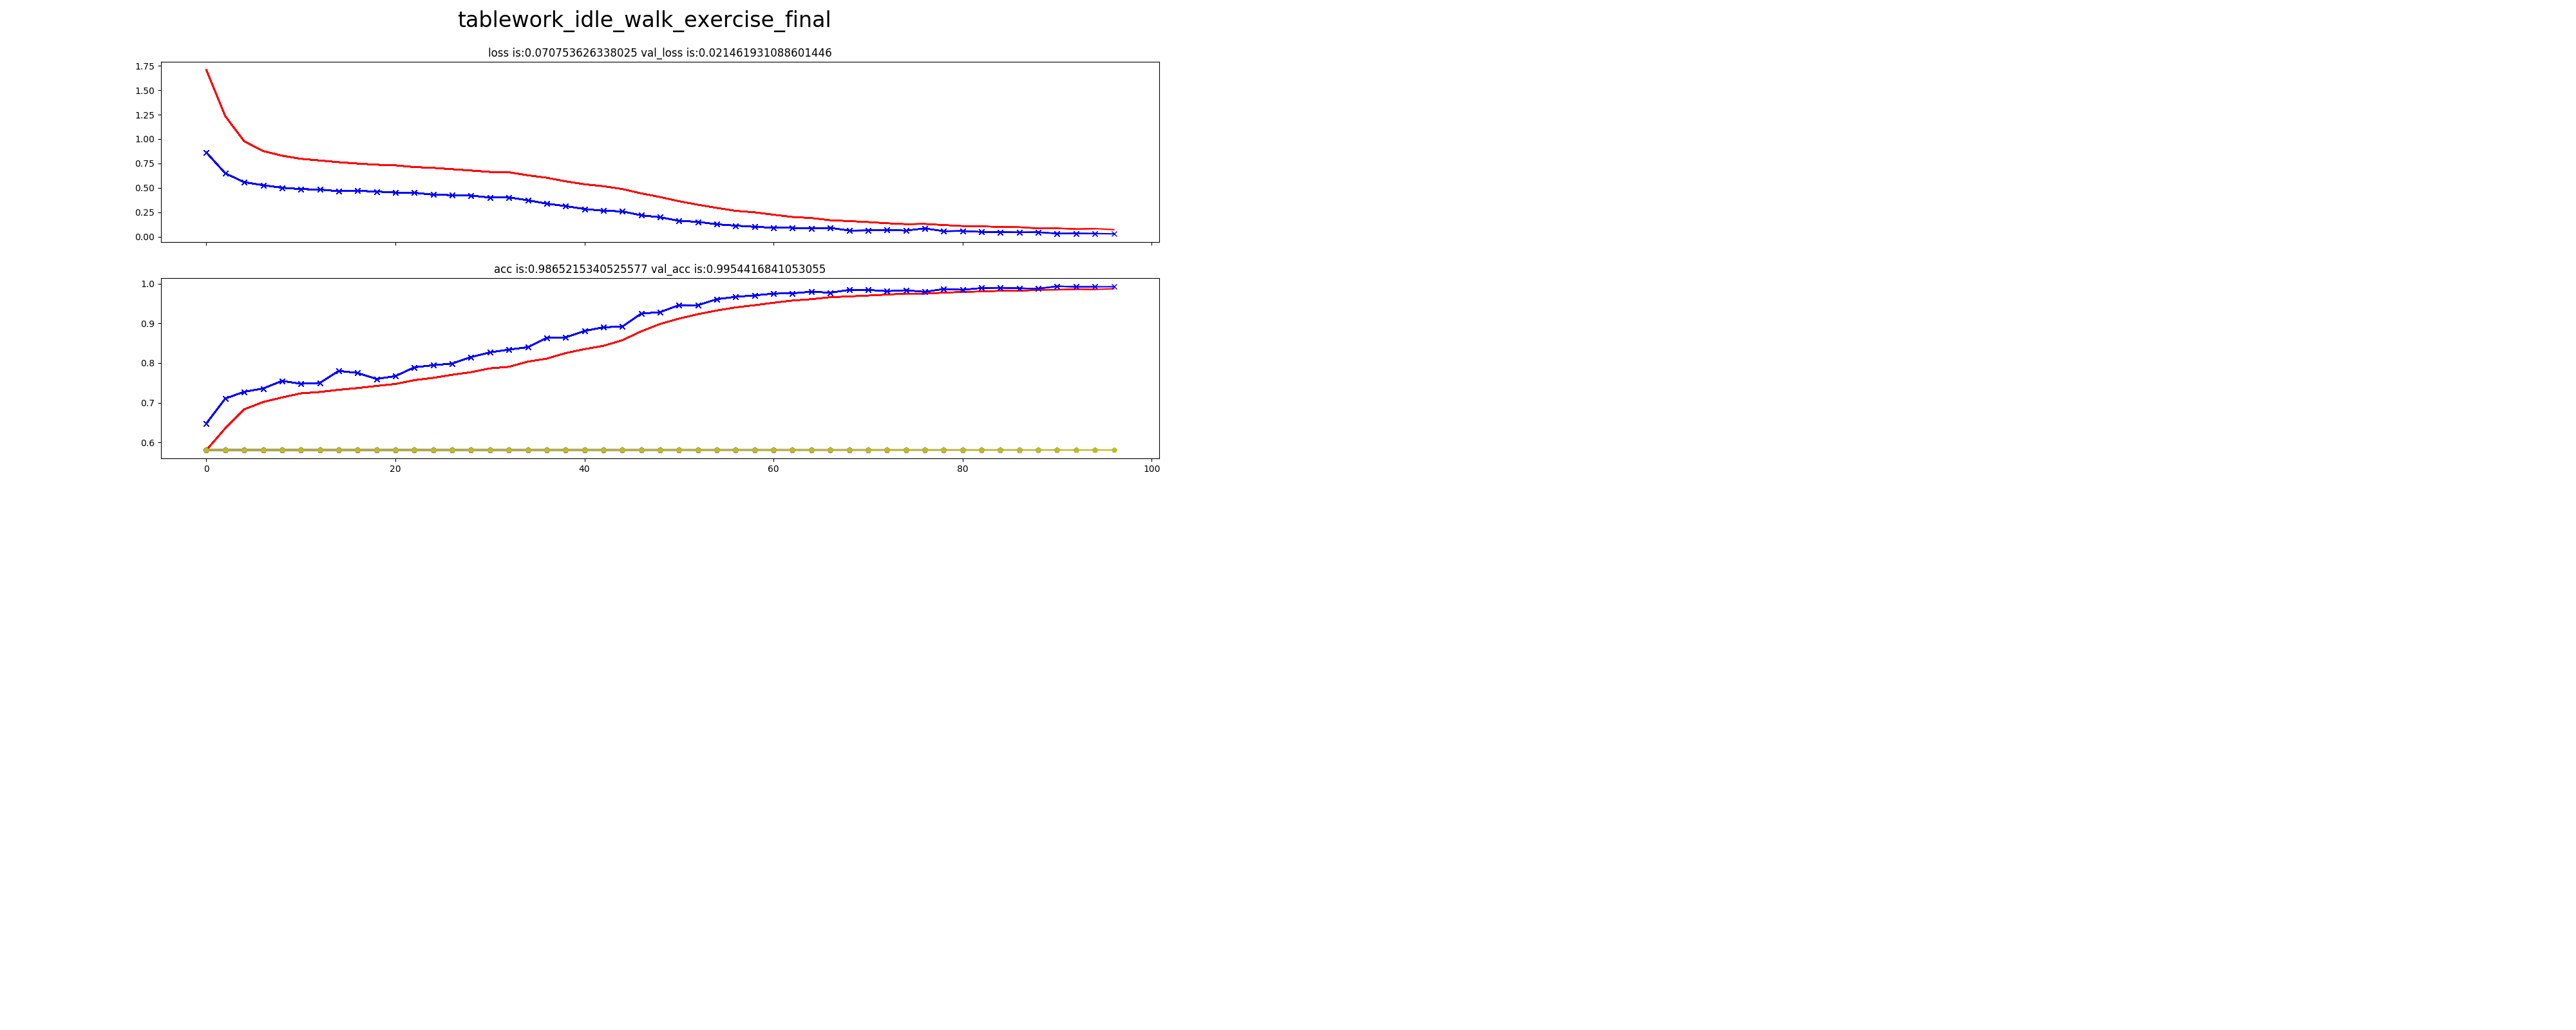

KeyboardInterrupt: 

In [272]:
# do training
VisualizeCallback.title = "tablework_idle_walk_exercise_final"
pattern_analyzer.fit(train_data['accel'], train_data['label_onehot'], epochs=300, batch_size=512, shuffle=True,
                  verbose=0, validation_data=[test_data['accel'], test_data['label_onehot']], 
                  callbacks=[ReduceLROnPlateau(patience=10, min_lr=0.00001, cooldown=30), VisualizeCallback],
                   sample_weight=train_data['label_weight'])

scores = desc_conv_model.evaluate(x=[test_data['accel']], y=[test_data['label_onehot']])
desc_conv_model.save("model/pattern_analyzer_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

In [273]:
scores = pattern_analyzer.evaluate(x=[test_data['accel']], y=[test_data['label_onehot']])
print(scores)
pattern_analyzer.save("model/pattern_analyzer_" + VisualizeCallback.title + " acc: " + str(scores[1]) + ".hdf5")

12724/12724 [==============================] - 6s 455us/step
[0.019195716039349196, 0.9933197107827727]


In [204]:
plot_model(model=pattern_analyzer, to_file="temp.png")

In [251]:
pred = pattern_analyzer.predict_on_batch(x=[test_data['accel']])
pred

array([[  9.95058450e-04,   9.98964548e-01,   1.27940266e-05,
          2.75824113e-05],
       [  8.51648808e-01,   2.93968618e-03,   1.70729980e-02,
          1.28338590e-01],
       [  9.99038339e-01,   5.20368167e-06,   6.62015402e-04,
          2.94375001e-04],
       ..., 
       [  2.21495298e-04,   2.81527286e-06,   9.99773443e-01,
          2.27382156e-06],
       [  3.50555456e-05,   2.51707744e-09,   3.39030412e-05,
          9.99930978e-01],
       [  4.55197332e-05,   7.85344856e-09,   4.18374766e-05,
          9.99912620e-01]], dtype=float32)